In [1]:
import math
import collections

import numpy as np
import sympy as sy
import matplotlib.pyplot as plt

from scipy.optimize import fsolve

from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# 0. 실행
- 아래 프로젝트 결과 실행
- https://github.com/YaelBenShalom/Mobile-Manipulation

In [2]:
# 0.1. 클라이언트 생성  
client = RemoteAPIClient()
# 0.2. 시뮬레이션 객체 가져오기
sim = client.require("sim")

In [3]:
joints = []
# 5개의 관절 가져오기
for i in range(5):
    joints.append(sim.getObject(f"/youBotArmJoint{i}"))

# Gripper Joint
joints.append(sim.getObject(f"/youBotGripperJoint2"))

for joint in joints:
    sim.setObjectInt32Param(
        joint,
        sim.jointintparam_dynctrlmode,
        sim.jointdynctrl_position,
    )

In [4]:
# 0.3. 데이터 로드
data = []
with open("configurations.csv", "r") as f:
    for line in f:
        row = line.strip().split(",")
        assert len(row) == 13
        data.append(row)
len(data)


1600

In [5]:
# 0.4. 각 스텝 실행
def run_step(row):
    j0, j1, j2, j3, j4 = row[3:8]
    g0 = row[-1]
    sim.setJointTargetPosition(joints[0], float(j0))
    sim.setJointTargetPosition(joints[1], float(j1))
    sim.setJointTargetPosition(joints[2], float(j2))
    sim.setJointTargetPosition(joints[3], float(j3))
    sim.setJointTargetPosition(joints[4], float(j4))
    # sim.setJointTargetPosition(joints[5], float(g0))


In [6]:
# 0.5. 시뮬레이션 실행
sim.setStepping(True)
sim.startSimulation()

# 0.6. 각 스텝 실행
for row in data:
    run_step(row)
    sim.step()

# 0.7. 시뮬레이션 종료
sim.stopSimulation()

# 1. Forward Kinematics

In [7]:
# 0.1. 클라이언트 생성  
client = RemoteAPIClient()
# 0.2. 시뮬레이션 객체 가져오기
sim = client.require("sim")

In [8]:
joints = []
# 5개의 관절 가져오기
for i in range(5):
    joints.append(sim.getObject(f"/youBotArmJoint{i}"))

# Gripper Joint
joints.append(sim.getObject(f"/youBotGripperJoint2"))

points = []
# Car 위치
points.append(sim.getObject(f"/youBot_ref"))
# 5개의 관절 위치 가져오기
for i in range(5):
    points.append(sim.getObject(f"/p{i}_ref"))
# End Effector 위치
points.append(sim.getObject(f"/pe_ref"))


for joint in joints:
    sim.setObjectInt32Param(
        joint,
        sim.jointintparam_dynctrlmode,
        sim.jointdynctrl_position,
    )

In [9]:
# 0.4. 각 스텝 실행
def run_step():
    j0 = sim.getJointPosition(joints[0])
    j0 += 0.002
    sim.setJointTargetPosition(joints[0], j0)
    j1 = sim.getJointPosition(joints[1])
    j1 += 0.002
    sim.setJointTargetPosition(joints[1], j1)
    j2 = sim.getJointPosition(joints[2])
    j2 += 0.002
    sim.setJointTargetPosition(joints[2], j2)
    j3 = sim.getJointPosition(joints[3])
    j3 += 0.002
    sim.setJointTargetPosition(joints[3], j3)
    j4 = sim.getJointPosition(joints[4])
    j4 += 0.002
    sim.setJointTargetPosition(joints[4], j4)
    je = sim.getJointPosition(joints[5])
    je = -0.050
    sim.setJointTargetPosition(joints[5], je)

    pc = sim.getObjectPosition(points[0])
    oc = sim.getObjectOrientation(points[0])
    pc = np.array(pc + oc)
    p0 = sim.getObjectPosition(points[1])
    p0 = np.array(p0)
    p1 = sim.getObjectPosition(points[2])
    p1 = np.array(p1)
    p2 = sim.getObjectPosition(points[3])
    p2 = np.array(p2)
    p3 = sim.getObjectPosition(points[4])
    p3 = np.array(p3)
    p4 =sim.getObjectPosition(points[5])
    p4 = np.array(p4)
    pe =sim.getObjectPosition(points[6])
    pe = np.array(pe)

    return (j0, j1, j2, j3, j4, je), (pc, p0, p1, p2, p3, p4, pe)

In [10]:
# 0.5. forward kinematics
def fk(pc, j0, j1, j2, j3, j4):
    # 월드 기준 자동차
    dc = pc[5]
    TWC = np.array([
        [np.cos(dc), -np.sin(dc), 0, pc[0]],
        [np.sin(dc),  np.cos(dc), 0, pc[1]],
        [         0,           0, 1, pc[2]],
        [         0,           0, 0,     1]
    ])

    # 자동차 -> joint-0
    TC0 = np.array([ # 좌표이동 및 y축을 기준으로 90도 회전
        [1, 0, 0, 0.0],
        [0, 1, 0, 0.166],
        [0, 0, 1, 0.099],
        [0, 0, 0, 1]
    ]) @ np.array([
        [np.cos(j0), -np.sin(j0), 0, 0],
        [np.sin(j0),  np.cos(j0), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TW0 = TWC @ TC0

    # joint-0 -> joint-1
    ay1 = np.pi / 2
    T01 = np.array([ # 좌표이동 및 y축을 기준으로 90도 회전
        [ np.cos(ay1), 0, np.sin(ay1), 0.0],
        [           0, 1,           0, 0.033],
        [-np.sin(ay1), 0, np.cos(ay1), 0.147],
        [           0, 0,           0, 1]
    ]) @ np.array([ # z축을 기준으로 j1만큼 회전
        [np.cos(j1), -np.sin(j1), 0, 0],
        [np.sin(j1),  np.cos(j1), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TW1 = TW0 @ T01

    # joint-1 -> joint-2
    T12 = np.array([ # 좌표이동, 회전 없음
        [1, 0, 0, -0.155],
        [0, 1, 0,  0.0],
        [0, 0, 1,  0.0],
        [0, 0, 0,  1]
    ]) @ np.array([ # z축을 기준으로 j2만큼 회전
        [np.cos(j2), -np.sin(j2), 0, 0],
        [np.sin(j2),  np.cos(j2), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TW2 = TW1 @ T12

    # joint-2 -> joint-3
    T23 = np.array([ # 좌표이동, 회전 없음
        [1, 0, 0, -0.135],
        [0, 1, 0,  0.0],
        [0, 0, 1,  0.0],
        [0, 0, 0,  1]
    ]) @ np.array([ # z축을 기준으로 j3만큼 회전
        [np.cos(j3), -np.sin(j3), 0, 0],
        [np.sin(j3),  np.cos(j3), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TW3 = TW2 @ T23

    # joint-3 -> joint-4
    ay4 = -np.pi / 2
    T34 = np.array([ # 좌표이동 및 y축을 기준으로 -90도 회전
        [ np.cos(ay4), 0, np.sin(ay4), -0.081],
        [           0, 1,           0,  0.0],
        [-np.sin(ay4), 0, np.cos(ay4),  0.0],
        [           0,  0,          0,  1]
    ]) @ np.array([ # z축을 기준으로 j4만큼 회전
        [np.cos(j4), -np.sin(j4), 0, 0],
        [np.sin(j4),  np.cos(j4), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TW4 = TW3 @ T34

    p0_hat = TWC @ np.array([ 0.0,   0.166, 0.099, 1])
    p1_hat = TW0 @ np.array([ 0.0,   0.033, 0.147, 1])
    p2_hat = TW1 @ np.array([-0.155, 0.0,   0.0,   1])
    p3_hat = TW2 @ np.array([-0.135, 0.0,   0.0,   1])
    p4_hat = TW3 @ np.array([-0.081, 0.0,   0.0,   1])
    pe_hat = TW4 @ np.array([ 0.0,   0.0,   0.123, 1])

    return p0_hat[:3], p1_hat[:3], p2_hat[:3], p3_hat[:3], p4_hat[:3], pe_hat[:3]

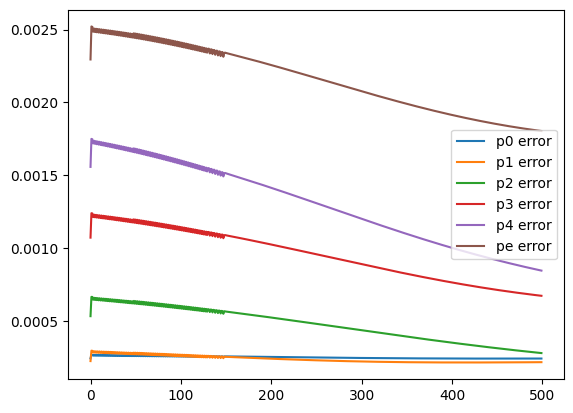

In [12]:
# 0.6.1. 로그 기록
n_steps = 500
log = np.zeros((n_steps, 6))

# 0.6.2. 시뮬레이션 실행
sim.setStepping(True)
sim.startSimulation()

# 0.6.3. 각 스텝 실행
for i in range(n_steps):
    (j0, j1, j2, j3, j4, je), (pc, p0, p1, p2, p3, p4, pe) = run_step()
    p0_hat, p1_hat, p2_hat, p3_hat, p4_hat, pe_hat = fk(pc,j0, j1, j2, j3, j4)
    log[i][0] = np.linalg.norm(p0 - p0_hat)
    log[i][1] = np.linalg.norm(p1 - p1_hat)
    log[i][2] = np.linalg.norm(p2 - p2_hat)
    log[i][3] = np.linalg.norm(p3 - p3_hat)
    log[i][4] = np.linalg.norm(p4 - p4_hat)
    log[i][5] = np.linalg.norm(pe - pe_hat)
    sim.step()

# 0.6.4. 시뮬레이션 종료
sim.stopSimulation()

# 0.6.5. 로그 시각화
plt.plot(log[:, 0], label="p0 error")
plt.plot(log[:, 1], label="p1 error")
plt.plot(log[:, 2], label="p2 error")
plt.plot(log[:, 3], label="p3 error")
plt.plot(log[:, 4], label="p4 error")
plt.plot(log[:, 5], label="pe error")
plt.legend()
plt.show()

# 2. DH Table

In [2]:
def dh_transformation(alpha, a, theta, d):
    T_alpha = sy.Matrix(
        [
            [1, 0, 0, 0],
            [0, sy.cos(alpha), -sy.sin(alpha), 0],
            [0, sy.sin(alpha), sy.cos(alpha), 0],
            [0, 0, 0, 1],
        ]
    )
    T_a = sy.Matrix(
        [
            [1, 0, 0, a],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ]
    )
    T_theta = sy.Matrix(
        [
            [sy.cos(theta), -sy.sin(theta), 0, 0],
            [sy.sin(theta), sy.cos(theta), 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ]
    )
    T_d = sy.Matrix(
        [
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, d],
            [0, 0, 0, 1],
        ]
    )
    return sy.simplify(T_alpha * T_a * T_theta * T_d)

In [22]:
theta_0, theta_1, theta_2, theta_3 = sy.symbols("theta_0 theta_1 theta_2 theta_3", real=True)
T01 = dh_transformation(np.pi / 2, 0.0330, theta_0, 0.1012)
print("T01:", T01)
T12 = dh_transformation(0, 0.1550, theta_1, 0.0000)
print("T12:", T12)
T23 = dh_transformation(0, 0.1348, theta_2, 0.0000)
print("T23:", T23)
T23 = dh_transformation(-np.pi / 2, 0.0005, theta_3, 0.0000)
print("T23:", T23)

T01: Matrix([[cos(theta_0), -sin(theta_0), 0, 0.0330000000000000], [6.12323399573677e-17*sin(theta_0), 6.12323399573677e-17*cos(theta_0), -1.00000000000000, -0.101200000000000], [1.0*sin(theta_0), 1.0*cos(theta_0), 6.12323399573677e-17, 6.19671280368561e-18], [0, 0, 0, 1]])
T12: Matrix([[cos(theta_1), -sin(theta_1), 0, 0.155000000000000], [sin(theta_1), cos(theta_1), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
T23: Matrix([[cos(theta_2), -sin(theta_2), 0, 0.134800000000000], [sin(theta_2), cos(theta_2), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])


In [ ]:
T23 = dh_transformation(0, 0.1348, theta_3, 0.0000)
print(T23)

# 3. Inverse Kinematics

In [453]:
# 0.1. 클라이언트 생성  
client = RemoteAPIClient()
# 0.2. 시뮬레이션 객체 가져오기
sim = client.require("sim")

In [454]:
joints = []
# 5개의 관절 가져오기
for i in range(5):
    joints.append(sim.getObject(f"/youBotArmJoint{i}"))

# Gripper Joint
joints.append(sim.getObject(f"/youBotGripperJoint2"))

points = []
# Car 위치
points.append(sim.getObject(f"/youBot_ref"))
# Joint-0 위치
points.append(sim.getObject(f"/p0_ref"))
# End Effector 위치
points.append(sim.getObject(f"/pe_ref"))
# Target 위치
points.append(sim.getObject(f"/Target"))

# joint 제어 모드 변경
for joint in joints:
    sim.setObjectInt32Param(
        joint,
        sim.jointintparam_dynctrlmode,
        sim.jointdynctrl_position,
    )

In [455]:
# joint angle 조회
def read_joints(joints):
    js = []
    for joint in joints:
        j = sim.getJointPosition(joint)
        js.append(j)
    return js

In [456]:
# point position & orientation 조회
def read_points(points):
    ps = []
    for point in points:
        p = sim.getObjectPosition(point)
        o = sim.getObjectOrientation(point)
        ps.append(np.array(p + o))
    return ps

In [457]:
# joint 제어
def control_joint(joints, thetas):
    for joint, j in zip(joints, thetas):
        sim.setJointTargetPosition(joint, j)

In [458]:
# gripper 제어
def control_gripper(gripper, state):
    position = sim.getJointPosition(gripper)
    position += 0.005 if state else -0.005
    sim.setJointTargetPosition(gripper, position)
    return position

In [459]:
# joint를 해당 위치로 점진적으로 이동
def trace_joint(joints, target_thetas):
    js = read_joints(joints)
    diff_sum = 0
    thetas = []
    for i, target in enumerate(target_thetas):
        diff = js[i] - target
        diff_sum += diff
        thetas.append(js[i] - min(0.05, max(-0.05, diff)))
    control_joint(joints, thetas)
    return diff_sum

In [460]:
# forward kinematics
def fk(thetas, params):
    j1, j2, j3, j4 = thetas[:4]
    j0, pc = params[:2]
    # 월드 기준 자동차
    dc = pc[5]
    TWC = np.array([
        [np.cos(dc), -np.sin(dc), 0, pc[0]],
        [np.sin(dc),  np.cos(dc), 0, pc[1]],
        [         0,           0, 1, pc[2]],
        [         0,           0, 0,     1]
    ])

    # 자동차 -> joint-0
    TC0 = np.array([ # 좌표이동 및 y축을 기준으로 90도 회전
        [1, 0, 0, 0.0],
        [0, 1, 0, 0.166],
        [0, 0, 1, 0.099],
        [0, 0, 0, 1]
    ]) @ np.array([
        [np.cos(j0), -np.sin(j0), 0, 0],
        [np.sin(j0),  np.cos(j0), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TW0 = TWC @ TC0

    # joint-0 -> joint-1
    ay1 = np.pi / 2
    T01 = np.array([ # 좌표이동 및 y축을 기준으로 90도 회전
        [ np.cos(ay1), 0, np.sin(ay1), 0.0],
        [           0, 1,           0, 0.033],
        [-np.sin(ay1), 0, np.cos(ay1), 0.147],
        [           0, 0,           0, 1]
    ]) @ np.array([ # z축을 기준으로 j1만큼 회전
        [np.cos(j1), -np.sin(j1), 0, 0],
        [np.sin(j1),  np.cos(j1), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TW1 = TW0 @ T01

    # joint-1 -> joint-2
    T12 = np.array([ # 좌표이동, 회전 없음
        [1, 0, 0, -0.155],
        [0, 1, 0,  0.0],
        [0, 0, 1,  0.0],
        [0, 0, 0,  1]
    ]) @ np.array([ # z축을 기준으로 j2만큼 회전
        [np.cos(j2), -np.sin(j2), 0, 0],
        [np.sin(j2),  np.cos(j2), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TW2 = TW1 @ T12

    # joint-2 -> joint-3
    T23 = np.array([ # 좌표이동, 회전 없음
        [1, 0, 0, -0.135],
        [0, 1, 0,  0.0],
        [0, 0, 1,  0.0],
        [0, 0, 0,  1]
    ]) @ np.array([ # z축을 기준으로 j3만큼 회전
        [np.cos(j3), -np.sin(j3), 0, 0],
        [np.sin(j3),  np.cos(j3), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TW3 = TW2 @ T23

    # joint-3 -> joint-4
    ay4 = -np.pi / 2
    T34 = np.array([ # 좌표이동 및 y축을 기준으로 -90도 회전
        [ np.cos(ay4), 0, np.sin(ay4), -0.081],
        [           0, 1,           0,  0.0],
        [-np.sin(ay4), 0, np.cos(ay4),  0.0],
        [           0,  0,          0,  1]
    ]) @ np.array([ # z축을 기준으로 j4만큼 회전
        [np.cos(j4), -np.sin(j4), 0, 0],
        [np.sin(j4),  np.cos(j4), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TW4 = TW3 @ T34

    pe_hat = TW4 @ np.array([ 0.0,   0.0,   0.123, 1])

    return pe_hat[:3]

In [461]:
def ik(thetas, params):
    pt = params[-1][:3]
    pe_hat = fk(thetas, params)
    # theta 범위 검증
    if thetas[0] < np.deg2rad(-90) or np.deg2rad(75) < thetas[0]:
        return 10, 0, 0, 0
    elif thetas[1] < np.deg2rad(-131.00) or np.deg2rad(131.00) < thetas[1]:
        return 10, 0, 0, 0
    elif thetas[2] < np.deg2rad(-102.00) or np.deg2rad(102.00) < thetas[2]:
        return 10, 0, 0, 0
    elif thetas[3] < np.deg2rad(-90.00) or np.deg2rad(90.00) < thetas[3]:
        return 10, 0, 0, 0
    return np.linalg.norm(pe_hat - pt), 0, 0, 0

In [462]:
def solve(js, ps):
    p0, pt = ps[1], ps[-1]
    diff = pt[:2] - p0[:2]
    angle = math.atan2(diff[1], diff[0])
    j0 = angle - p0[-1] - np.pi / 2
    target_thetas = fsolve(
        ik,
        [js[1], js[2], js[3], js[4]],
        [j0, ps[0], ps[-1]]
    )
    return np.concatenate((np.array([j0]), target_thetas))

In [467]:
n_steps = 400

# 시뮬레이션 실행
sim.setStepping(True)
sim.startSimulation()

# 각 스텝 실행
js = read_joints(joints)
ps = read_points(points)
target_thetas = solve(js, ps)
place_thetas = [np.pi, -np.pi / 6, -np.pi / 2.7, -np.pi / 3, 0]
base_thetas = [0, 0, 0, 0, 0]
stage = 0
gripper_positions = collections.deque(maxlen=100)
for i in range(n_steps):
    if stage == 0: # move to target
        diff_sum = trace_joint(joints, target_thetas)
        if abs(diff_sum) < 0.005:
            stage = 1
    elif stage == 1: # grip target
        position = control_gripper(joints[-1], True)
        gripper_positions.append(position)
        if len(gripper_positions) > 5 and np.abs(gripper_positions[-1] - gripper_positions[-5]) < 0.001:
            stage = 2
    elif stage == 2:  # pick the target
        target_thetas[0] = np.pi
        target_thetas[1] = -np.pi / 12
        target_thetas[2] = -np.pi / 6
        diff_sum = trace_joint(joints, target_thetas)
        if abs(diff_sum) < 0.005:
            stage = 3
    elif stage == 3: # move to place
        diff_sum = trace_joint(joints, place_thetas)
        if abs(diff_sum) < 0.005:
            stage = 4
    elif stage == 4: # place the target
        position = control_gripper(joints[-1], False)
        gripper_positions.append(position)
        if len(gripper_positions) > 5 and np.abs(gripper_positions[-1] - gripper_positions[-5]) < 0.001:
            stage = 5
    elif stage == 5: # move to base
        diff_sum = trace_joint(joints, base_thetas)
        if abs(diff_sum) < 0.005:
            stage = 6
    sim.step()

# 시뮬레이션 종료
sim.stopSimulation()

/var/folders/zt/d4hf1bc92d5527jl1y_x0drc0000gn/T/ipykernel_19313/3481707928.py:6: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  target_thetas = fsolve(
